# Database Analysis

Contains: 
1. Distribution of Slides per Train, Valid, Test Datasets
2. Distribution of Pixel Areas in Percent

## Loading Requirements

In [10]:
#Imports 
import sys
sys.path.insert(0, '..')
from pandasql import sqldf
from slide.process_slides import *
from fastai.vision import *
import matplotlib as mpl

In [11]:
#Folders
image_folder = "/home/klose/Data/crops_rescaled" #contains images
annotations_file = "/home/klose/Data/CMC_Tumor_Tub_Pleo.json" #contains annotations in COCO format
csv_path =  "/home/klose/Data/datasets.csv" #contains slide names

In [12]:
#Choose Dataset to analyse
# dataset_type = "pleomorphism_segmentation"
# dataset_type = "tubule_formation_segmentation"
dataset_type = "mammaCA_tumor_segmentation"
# dataset_type = "scc_tumor_segmentation"

In [13]:
# Class Distribution for each Dataset
if dataset_type == "pleomorphism_segmentation": 
    reduced_label_dict = {'other':0,'pleo 1': 2, 'pleo 2': 3, 'pleo3': 4}  
    poly_id = "pleo_id"
    name = 'supercategory_Pleo'
if dataset_type == "tubule_formation_segmentation":
    reduced_label_dict = {'other':0,'tubular': 1}
    poly_id = 'tub_id'
    name = 'supercategory_TubFormation'
if dataset_type == "mammaCA_tumor_segmentation":
    image_folder = "/home/klose/Data/crops_rescaled"
    poly_id = 'tumor_id'
    name = 'supercategory_1'
    reduced_label_dict = {'Other':0, 'Bg':1,'Tumor': 2, 'KeinTumor': 3}
if dataset_type == "scc_tumor_segmentation":
    image_folder = "/home/klose/Data/SCC_images"
    #seperate annotation file, because its a different dataset
    annotations_file = '/home/klose/Data/CATCH_Daten/SCC_Tumor_NonTumor.json'
    csv_path =  "/home/klose/Data/SCC_datasets.csv"
    poly_id = "tumor_id"
    name = 'supercategory_scc'
    reduced_label_dict = {'Other':0, 'Bg':1,'Tumor': 2, 'KeinTumor': 3}

In [14]:
#load slides
train_files, valid_files, test_files= load_slides(["train","valid", "test"], equal_sampling = False, target_folder = image_folder, csv_path = csv_path, annotations_file = annotations_file, label_dict = reduced_label_dict, dataset_type = dataset_type)

100%|██████████| 300/300 [00:00<00:00, 1342893.49it/s]


In [15]:
print("train slides: ", len(train_files))
print("valid slides: ", len(valid_files))
print("test slides: ", len(test_files))

train slides:  176
valid slides:  61
test slides:  63


In [16]:
#if True: train, valid and test datasets will be analized seperately
all_seperate = True 

In [17]:
#combine all files in one list - if seperate = False
all_files = []

if all_seperate:
    all_files.append(train_files)
    all_files.append(valid_files)
    all_files.append(test_files)
else: 
    all_files.extend(train_files)
    all_files.extend(valid_files)
    all_files.extend(test_files)


## 1. Distribution of Slides per Train, Valid, Test Datasets

In [18]:
#get areas in whole dataset
if all_seperate == False:
    train_areas = []
    for image_path in all_files:
        with open(annotations_file) as f:
            #read file
            data = json.load(f) 
            #get image id
            name = Path(image_path).name
            image_id = [i.get('id') for i in data.get("images") if i.get("file_name") == name][0]
            #get annotations for image id
            polygons = [anno for anno in data['annotations'] if anno["image_id"] == image_id]
            #get annotations areas and class id for image id
            polygons_areas = [(poly['image_id'] , poly[poly_id], poly["area"] )for poly in polygons]
            train_areas.extend(polygons_areas)
else:
    train_areas_lists = []
    for file_class in all_files:
        train_areas = []
        for image_path in file_class:
            with open(annotations_file) as f:
                #read file
                data = json.load(f) 
                #get image id
                name = Path(image_path).name
                image_id = [i.get('id') for i in data.get("images") if i.get("file_name") == name][0]
                #get annotations for image id
                polygons = [anno for anno in data['annotations'] if anno["image_id"] == image_id]
                #get annotations areas and class id for image id
                #list with (205, 3, 20767598.0) tupels
                polygons_areas = [(poly['image_id'] , poly[poly_id], poly["area"] )for poly in polygons]
                train_areas.extend(polygons_areas)
        train_areas_lists.append(train_areas)


In [19]:
#create dataframe
if all_seperate == False:
    df = pd.DataFrame(train_areas, columns =['SlideId', 'class_id', "Area"])
    print(df.head(4))
else: 
    df_train = pd.DataFrame(train_areas_lists[0], columns =['SlideId', 'class_id', "Area"])
    df_train["dataset"] = "train"
    df_valid = pd.DataFrame(train_areas_lists[1], columns =['SlideId', 'class_id', "Area"])
    df_valid["dataset"] = "valid"
    df_test = pd.DataFrame(train_areas_lists[2], columns =['SlideId', 'class_id', "Area"])
    df_test["dataset"] = "test"

    df = df_train.append(df_valid)
    df = df.append(df_test)


/tmp/ipykernel_1861010/2300107292.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_train.append(df_valid)
/tmp/ipykernel_1861010/2300107292.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_test)


In [20]:
#Dataframe overview
sqldf("SELECT * from df order By class_id asc limit 3")

,SlideId,class_id,Area,dataset
0,30,0,135561.5,train
1,182,0,7958.5,train
2,182,0,8097.5,train


In [21]:
sqldf("SELECT count(Distinct SlideId) num_roi_df from df")

,num_roi_df
0,294


Make 2 Tables
1. area per class id
2. slides per class id

In [22]:
#area per class id
if all_seperate == False:
    table_areas_allSlides = sqldf("SELECT class_id, sum(Area) as category_area from df group By class_id")
else: 
    table_areas_allSlides = sqldf("SELECT class_id, dataset, sum(Area) as category_area from df group By class_id")

In [23]:
# table_areas_allSlides[:5]

In [24]:
# slides per class id
if all_seperate == False:
    table_num_classes = sqldf("SELECT class_id, count(Distinct SlideId) as num_slides from df group By class_id")
else: 
    table_num_classes = sqldf("SELECT class_id, dataset,count(Distinct SlideId) as num_slides from df group By dataset, class_id")

In [25]:
# table_num_classes[:4]

In [26]:
#map names instead of class_id
d_swap = {v: k for k, v in reduced_label_dict.items()}
table_num_classes = table_num_classes.replace({"class_id": d_swap})

In [27]:
#set background color
mpl.rcParams['figure.facecolor'] = 'white'

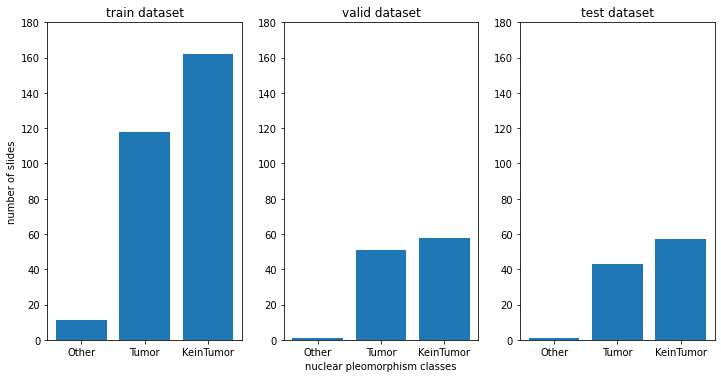

In [28]:
#visualize number of slides
if all_seperate == False:
    table_num_classes.plot(kind = 'bar', x = 'class_id', y='num_slides', color = "steelblue", rot=0)
else: 
    #einzelne plots machen
    train_df = sqldf("SELECT class_id, dataset, num_slides from table_num_classes where dataset == 'train'")
    valid_df = sqldf("SELECT class_id, dataset, num_slides from table_num_classes where dataset == 'valid'")
    test_df = sqldf("SELECT class_id, dataset, num_slides from table_num_classes where dataset == 'test'")
    
    #initialize subplot with number rows and cols
    figure, axis = plt.subplots(1, 3, figsize = (10,5))
    figure.tight_layout()

    # axis[0].plot() #(kind = 'bar', x = 'class_id', y='num_slides', color = "steelblue", rot=0))
    axis[0].bar(train_df.class_id, train_df.num_slides)
    axis[0].set_title("train dataset")
    axis[0].set_ylabel("number of slides")
    axis[0].set_ylim([0,180])
    axis[1].bar(valid_df.class_id, valid_df.num_slides)
    axis[1].set_title("valid dataset")
    axis[1].set_ylim([0,180])
    axis[2].bar(test_df.class_id, test_df.num_slides)
    axis[2].set_title("test dataset")
    axis[2].set_ylim([0,180])

    if dataset_type  == "tubule_formation_segmentation": 
        axis[1].set_xlabel("tubule formation classes")
    if dataset_type  == "mammaCA_tumor_segmentation": 
        axis[1].set_xlabel("tumor classes")
    if dataset_type  == "scc_tumor_segmentation": 
        axis[1].set_xlabel("tumor classes")
    else: 
        axis[1].set_xlabel("nuclear pleomorphism classes")


## 2. Distribution of Pixel Areas in Percent

Calculate Area in Pixels and Percentage (Pixel per whole area)

In [29]:
#whole area
area_all_classes = sum(table_areas_allSlides["category_area"])
#add new column with constant value
table_areas_allSlides["whole_area"] = area_all_classes
table_areas_allSlides

,class_id,dataset,category_area,whole_area
0,0,train,3.092156e+06,1.834589e+09
1,2,train,1.345966e+09,1.834589e+09
2,3,train,4.855311e+08,1.834589e+09


In [30]:
#calculate area percentage
table_areas_allSlides_perc = sqldf("SELECT class_id, (category_area/whole_area)*100 as category_area_perc from table_areas_allSlides")
table_areas_allSlides_perc

,class_id,category_area_perc
0,0,0.168548
1,2,73.366066
2,3,26.465386


<AxesSubplot: xlabel='class_id'>

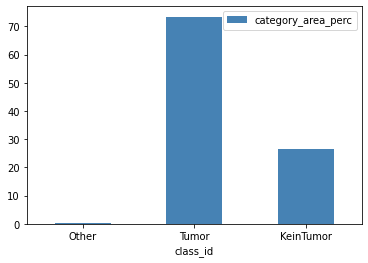

In [31]:
#visualize (percentage)
table_areas_allSlides_perc = table_areas_allSlides_perc.replace({"class_id": d_swap})
table_areas_allSlides_perc.plot(kind = 'bar', x = 'class_id', y='category_area_perc', color = "steelblue", rot=0)